# MATH 497: Intro to Machine Learning Final

## Jenny Fothergill

`data` is a random sample from the following mixture of Normal distribution with $\delta$ unknown:

$$\delta N(7,0.5^{2}) +(1-\delta)N(10,0.5^{2})$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
from scipy.special import logit, expit

plt.rcParams["font.size"] = 20

bins=25

data = np.load("Fothergill_final_data.npy")
print(f"data shape : {data.shape}")

data shape : (200,)


In [10]:
# probability model
def mixed_norm(x, delta):
    return delta * norm.pdf(x, 7, 0.5**2) + (1-delta) * norm.pdf(x, 10, 0.5**2)

def likelihood(delta):
    return np.prod(mixed_norm(data, delta))

(a) Implement an independence chain MCMC procedure to simulate from the posterior distribution
of $\delta$.

In [3]:
steps = 10000

ic_deltas = np.zeros(steps)
idelta = 0.5

for i in range(steps):
    delta_star = np.random.uniform()
    
    ratio = likelihood(delta_star) / likelihood(idelta)
    r = np.random.rand()
    if r < ratio:
        idelta = delta_star
    ic_deltas[i] = idelta

In [4]:
plt.plot(ic_deltas, label="delta sample path")
ic_delta_avg = np.mean(ic_deltas[steps//2:]) # average of the last half of the samples
plt.plot(np.ones(ic_deltas.shape) * ic_delta_avg, label="average delta")
plt.xlabel("step")
plt.ylabel("delta value")
plt.title("Sample path")
plt.legend()
plt.show()

x = np.linspace(min(data), max(data))

plt.hist(data, bins=bins, label="data histogram")
plt.plot(x, max(np.histogram(data, bins=bins)[0]) * mixed_norm(x, ic_delta_avg), label=f"model with delta={ic_delta_avg:.2f}")
plt.xlabel("value")
plt.ylabel("probability/number of samples")
plt.title("Algorithm output")
plt.legend()
plt.show()

(b) Implement a random walk chain with $\delta^{*} = \delta(t) + \epsilon$ with $\epsilon ∼ Unif(-1,1)$.

$$R(\delta^{t},\delta^{*}) =\frac{f(\delta^{*})h(\delta^{t}-\delta^{*})}{f(\delta^{t})h(\delta^{*}-\delta^{t})}$$

where $h(\delta^{t}-\delta^{*}) = 0.5$ because $|\delta^{t}-\delta^{*}| = \epsilon$ and the uniform distribution is a stepwise function with area = 1

and $f(\delta) = p(\delta)L(\delta|y)$

In [11]:
steps = 10000

rw_deltas = np.zeros(steps)
idelta = 0.8

x = np.linspace(min(data), max(data))

for i in range(steps):
    epsilon = np.random.uniform(-1, 1)
    delta_star = idelta + epsilon
    
    if uniform.pdf(delta_star) > 0:
        ratio = (
            uniform.pdf(delta_star) * likelihood(delta_star) * 0.5 / 
            (uniform.pdf(idelta) * likelihood(idelta) * 0.5)
        )

        r = np.random.rand()
        if r < ratio:
            idelta = delta_star
    rw_deltas[i] = idelta

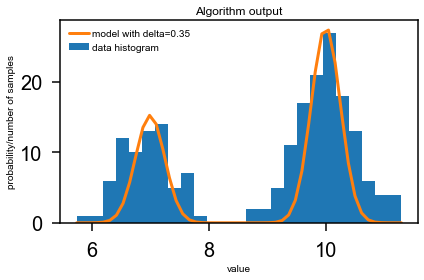

In [12]:
plt.plot(rw_deltas, label="delta sample path")
rw_delta_avg = np.mean(rw_deltas[steps//2:]) # average of the last half of the samples
plt.plot(np.ones(rw_deltas.shape) * rw_delta_avg, label="average delta")
plt.xlabel("step")
plt.ylabel("delta value")
plt.title("Sample path")
plt.legend()
plt.show()

x = np.linspace(min(data), max(data))

plt.hist(data, bins=bins, label="data histogram")
plt.plot(x, max(np.histogram(data, bins=bins)[0]) * mixed_norm(x, rw_delta_avg), 
         label=f"model with delta={rw_delta_avg:.2f}")
plt.xlabel("value")
plt.ylabel("probability/number of samples")
plt.title("Algorithm output")
plt.legend()
plt.show()

(c) Reparameterize the problem letting $U = log{\frac{\delta}{1−\delta}}$ and $U^{*} = u(t) +\epsilon$. Implement a random walk chain in U-space as in Equation (7.8)

the `logit` function of $\delta$ is $log{\frac{\delta}{1−\delta}}$

the `expit` function is the inverse of `logit` and the expit of $u$ is $\frac{1}{1+e^{-u}}$

$|J(u)|$ is the derivative of $\delta$ w.r.t. $u$ or $\frac{d\delta}{du}$

$\delta = \frac{1}{1+e^{-u}}$ so $\frac{d\delta}{du} = \frac{e^{-u}}{(1+e^{-u})^{2}}$

In [7]:
steps = 10000

rp_deltas = np.zeros(steps)
idelta = 0.2
iu = logit(idelta)

def jacobian(u):
    return np.exp(-u) * expit(u)**2
    

x = np.linspace(min(data), max(data))

for i in range(steps):
    epsilon = np.random.uniform(-1, 1)
    u_star = iu + epsilon
    
    ratio = (
        jacobian(u_star) * likelihood(expit(u_star)) * 0.5 / 
        (jacobian(iu) * likelihood(expit(iu)) * 0.5)
    )

    r = np.random.rand()
    if r < ratio:
        iu = u_star
    idelta = expit(iu)
    rp_deltas[i] = idelta

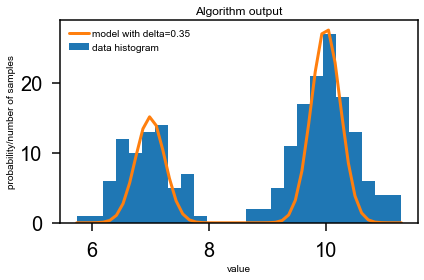

In [8]:
plt.plot(rp_deltas, label="delta sample path")
rp_delta_avg = np.mean(rp_deltas[steps//2:]) # average of the last half of the samples
plt.plot(np.ones(rp_deltas.shape) * rp_delta_avg, label="average delta")
plt.xlabel("step")
plt.ylabel("delta value")
plt.title("Sample path")
plt.legend()
plt.show()

x = np.linspace(min(data), max(data))

plt.hist(data, bins=bins, label="data histogram")
plt.plot(x, max(np.histogram(data, bins=bins)[0]) * mixed_norm(x, rp_delta_avg), 
         label=f"model with delta={rp_delta_avg:.2f}")
plt.xlabel("value")
plt.ylabel("probability/number of samples")
plt.title("Algorithm output")
plt.legend()
plt.show()

# All plots

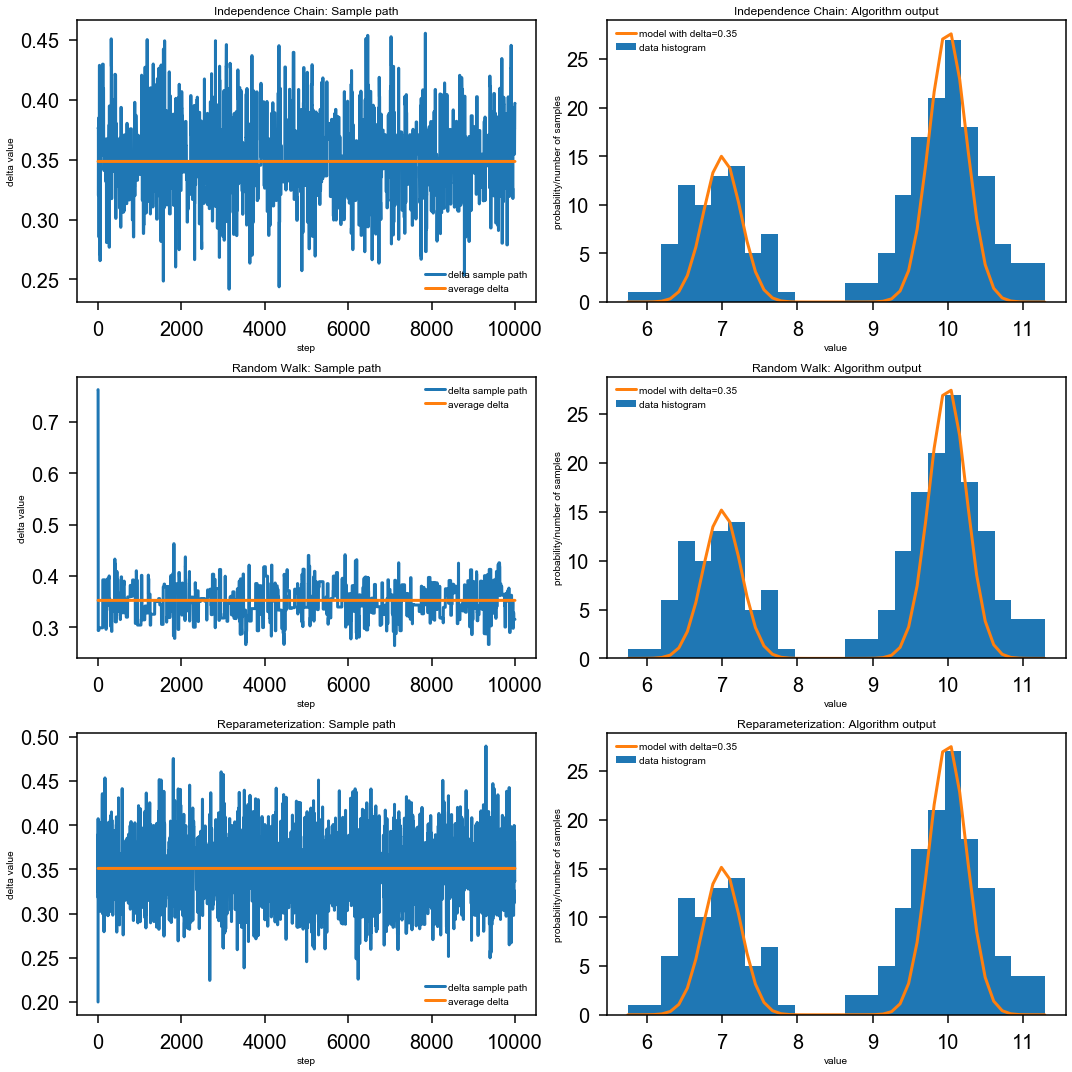

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))

ax[0,0].plot(ic_deltas, label="delta sample path")
ax[0,0].plot(np.ones(ic_deltas.shape) * ic_delta_avg, label="average delta")
ax[0,0].set_xlabel("step")
ax[0,0].set_ylabel("delta value")
ax[0,0].set_title("Independence Chain: Sample path")
ax[0,0].legend()

x = np.linspace(min(data), max(data))

ax[0,1].hist(data, bins=bins, label="data histogram")
ax[0,1].plot(x, max(np.histogram(data, bins=bins)[0]) * mixed_norm(x, ic_delta_avg), 
             label=f"model with delta={ic_delta_avg:.2f}")
ax[0,1].set_xlabel("value")
ax[0,1].set_ylabel("probability/number of samples")
ax[0,1].set_title("Independence Chain: Algorithm output")
ax[0,1].legend()


ax[1,0].plot(rw_deltas, label="delta sample path")
ax[1,0].plot(np.ones(rw_deltas.shape) * rw_delta_avg, label="average delta")
ax[1,0].set_xlabel("step")
ax[1,0].set_ylabel("delta value")
ax[1,0].set_title("Random Walk: Sample path")
ax[1,0].legend()



ax[1,1].hist(data, bins=bins, label="data histogram")
ax[1,1].plot(x, max(np.histogram(data, bins=bins)[0]) * mixed_norm(x, rw_delta_avg), 
             label=f"model with delta={rw_delta_avg:.2f}")
ax[1,1].set_xlabel("value")
ax[1,1].set_ylabel("probability/number of samples")
ax[1,1].set_title("Random Walk: Algorithm output")
ax[1,1].legend()


ax[2,0].plot(rp_deltas, label="delta sample path")
ax[2,0].plot(np.ones(rp_deltas.shape) * rp_delta_avg, label="average delta")
ax[2,0].set_xlabel("step")
ax[2,0].set_ylabel("delta value")
ax[2,0].set_title("Reparameterization: Sample path")
ax[2,0].legend()


ax[2,1].hist(data, bins=bins, label="data histogram")
ax[2,1].plot(x, max(np.histogram(data, bins=bins)[0]) * mixed_norm(x, rp_delta_avg), 
             label=f"model with delta={rp_delta_avg:.2f}")
ax[2,1].set_xlabel("value")
ax[2,1].set_ylabel("probability/number of samples")
ax[2,1].set_title("Reparameterization: Algorithm output")
ax[2,1].legend();